Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

In [2]:
# Импорт модулей:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

### Загрузка датафреймов

In [3]:
path_to_file = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
customers = pd.read_csv(path_to_file)

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
 
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [4]:
path_to_file = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
orders = pd.read_csv(path_to_file, parse_dates=['order_purchase_timestamp',
                                                'order_approved_at',
                                                'order_delivered_carrier_date',
                                                'order_delivered_customer_date',
                                                'order_estimated_delivery_date'])

olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

In [5]:
path_to_file = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'
items = pd.read_csv(path_to_file)

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

### Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

проведем исследование данных:

In [6]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [7]:
orders[orders['order_approved_at'].isnull()].order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

In [8]:
orders[orders['order_approved_at'].notnull()].order_status.value_counts()

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

Очевидно, что для определения факта покупки использовать только лишь поле подтверждения оплаты заказа нельзя, т.к. есть заказы оплаченные, но со статусом canceled. Следовательно придется использовать поле order_status. Мы можем точно исключить статусы canceled, unavailable т.к. название говорит само за сабя и статус created, т.к. по нему нет оплат. Остальные статусы будем считать "покупкой", т.к. по ним уже есть оплата и они могут быть доставлены.

Так же есть несколько странных заказов без оплаты, но с доставкой. Возможно это ошибка системы, или заказы например со скидкой на 100%. По имеющимся данным однозначно ответить нельзя, в любом случае, их кол-во на общем фоне доставленных заказов очень мало и не должно вносить каких либо значимых влияний в расчетах. Так же если заказ доставлен, правильнее считать его все же осуществленной покупкой.

In [9]:
orders[orders['order_approved_at'].isnull()].query('order_status=="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


## Задание 1 - Сколько у нас пользователей, которые совершили покупку только один раз? 

т.к. у нас заказы в orders, а уникальные пользователи в customers, необходимо объеденить эти таблицы. Осмотрим их:

In [10]:
orders.customer_id.nunique()

99441

In [11]:
customers.customer_id.nunique()

99441

In [12]:
#кол-во строк и customer_id совпадет, можно делать обычный inner join по полю customer_id:
customers_orders = customers.merge(orders, how = 'inner', on = 'customer_id')

In [13]:
#создадим дата фрейм, в котором пользователи с покупкой более одной - отфильтруем полный датасет по заказам
#с подходящим статусом, сделаем группировку по пользователям и возьмем сумму от заказов.
orders_by_customers = customers_orders.query("order_status not in ('canceled', 'unavailable', 'created')") \
                                      .groupby('customer_unique_id', as_index=False) \
                                      .agg({'order_status': 'count'})

In [14]:
#выведем ответ на данное задание - кол-во пользователей с одним заказом:
customers_with_one = orders_by_customers.query('order_status == 1').order_status.sum()
print(f"{customers_with_one} пользователей совершили покупку только один раз.")

92099 пользователей совершили покупку только один раз.


## Задание 2 - Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [15]:
#Для агрегации по времени воспользуемся методом resample. Сначала для удобства переведем в индексы даты заказов.
orders_res = orders.set_index('order_purchase_timestamp').sort_values('order_purchase_timestamp')

In [16]:
#теперь мы можем саггрегировать все заказы по месяцам, исключить доставленные и расчитать среднее значение:
orders_res.query('order_status != "delivered"').resample('M').order_status.count().mean().round()

114.0

#### ответ на задание - в среднем не доставляется 114 заказов в месяц

выполним детализацию данных:

In [17]:
#сгруппируем по месяцу и статусу
orders_res_detail = orders_res.query('order_status != "delivered"').resample('M').order_status.value_counts().to_frame()
orders_res_detail

order_status
order_purchase_timestamp order_status              
2016-09-30               canceled                 2
                         shipped                  1
2016-10-31               canceled                24
                         invoiced                18
                         shipped                  8
...                                             ...
2018-08-31               invoiced                23
                         unavailable              7
2018-09-30               canceled                15
                         shipped                  1
2018-10-31               canceled                 4

[113 rows x 1 columns]

In [18]:
#переименуем колонку со значениями и сбросим индексы для дальнейшей визуализации
orders_res_detail = orders_res_detail.rename(columns = {'order_status':'values'}).reset_index()

In [19]:
#выполним цель задания - детализацию средних значений недоставок по месяцам
orders_res_detail.groupby('order_status').mean().round()

,values
order_status,
approved,1.0
canceled,26.0
created,2.0
invoiced,15.0
processing,16.0
shipped,48.0
unavailable,29.0


самые частые причины - заказ в пути, отменен, или недоступен

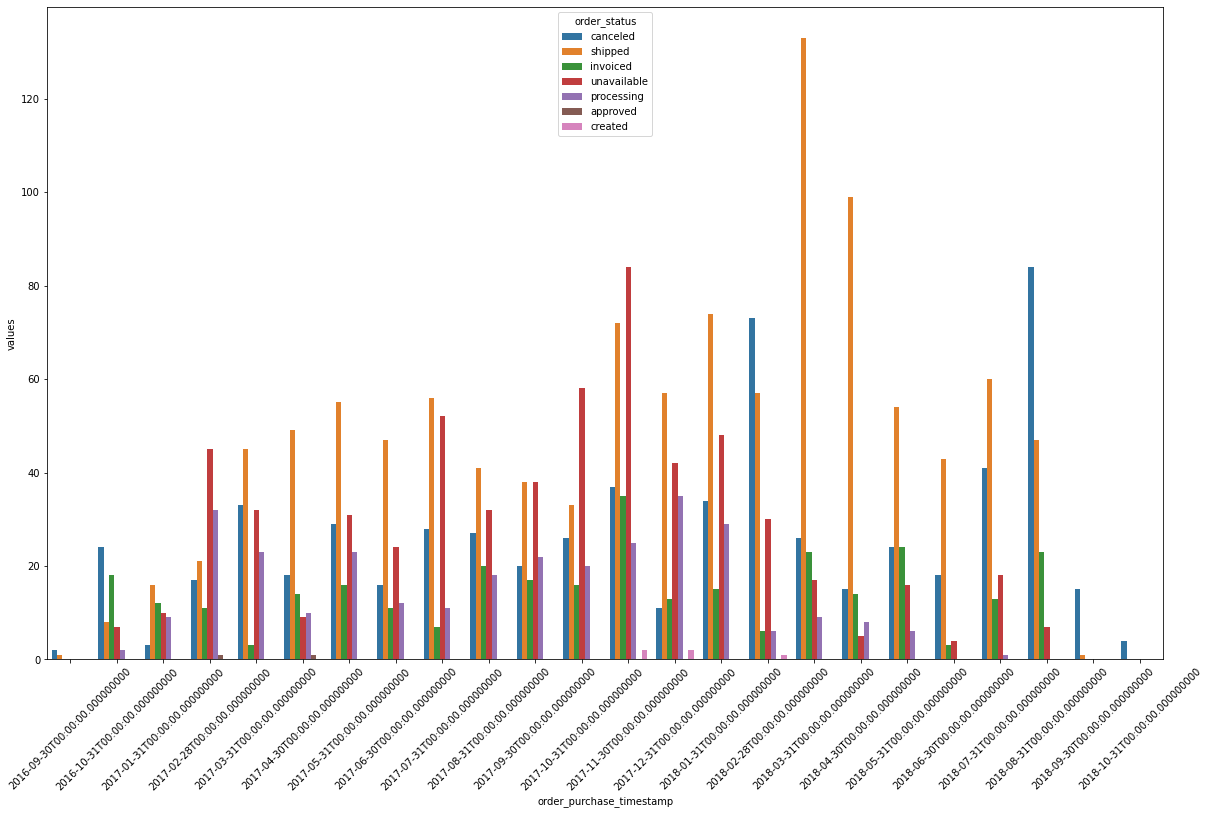

In [20]:
#факультативно выполним визуализацию причин:
plt.figure(figsize=(20, 12))
sns.barplot(x="order_purchase_timestamp", hue="order_status", y="values", data=orders_res_detail)
plt.xticks(rotation=45)
plt.show()

## Задание 3 - По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Для начала необходимо объединить таблицы с заказами "orders" и товарами "items". Исследуем данные:

In [21]:
orders.order_id.nunique()

99441

In [22]:
items.order_id.nunique()

98666

In [23]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [24]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [25]:
orders.order_id.value_counts().max()

1

In [26]:
items.order_id.value_counts().max()

21

что мы получаем:
1. Уникальных заказов в таблице orders больше, чем в items, следовательно есть пустые заказы без товаров совсем.
2. Т.к. в заказе может быть несколько товаров, в таблице items строки с заказами повторяются.

In [27]:
# Объединим таблицы, использую метод inner. Мы потеряем заказы без товаров, 
# но они нас не интересуют для выполнения данной задачи.
orders_items = orders.merge(items, how = 'inner', on = 'order_id')

In [28]:
orders_items.shape

(112650, 14)

In [29]:
orders_items.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [30]:
orders_items.order_status.value_counts()

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [31]:
#Для данной задачи для агрегации времени используем для разнообразия метод .dt
orders_items['day_of_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

In [32]:
#отфультруем состоявшиеся заказы, сгруппируем по продуктам и суммируем кол-во заказов продуктов по дням недели.
top_days = orders_items.query("order_status not in ('canceled', 'unavailable', 'created')") \
                            .groupby('product_id') \
                            .day_of_week \
                            .value_counts() \
                            .to_frame() \
                            .rename(columns = {'day_of_week':'values'}) \
                            .reset_index() \
                            .sort_values(['product_id', 'day_of_week'])

In [33]:
top_days

,product_id,day_of_week,values
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60886,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60887,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
60888,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60885,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [34]:
#сгруппируем по продукту и объемам продаж, переведя дни недели в список и отсортируем по объемам продаж.
top_days_list = top_days.groupby(['product_id', 'values']) \
                        .agg({'day_of_week': list}) \
                        .sort_values('values', ascending=False) \
                        .reset_index()

In [35]:
top_days_list

,product_id,values,day_of_week
0,422879e10f46682990de24d770e7f83d,93,[Wednesday]
1,99a4788cb24856965c36a24e339b6058,92,[Monday]
2,aca2eb7d00ea1a7b8ebd4e68314663af,89,[Thursday]
3,aca2eb7d00ea1a7b8ebd4e68314663af,87,[Friday]
4,aca2eb7d00ea1a7b8ebd4e68314663af,85,[Tuesday]
...,...,...,...
43576,654feb81aa65850b1962980f21be1525,1,[Wednesday]
43577,654eb5dabfc564fb748489541b4ca4a6,1,[Thursday]
43578,654cf8b68265f0efb5d140cb8fc1b30d,1,[Sunday]
43579,654ccc4e5459e7ba6b8d9fb04c45b9db,1,[Wednesday]


In [36]:
#уберем дубликаты в product_id, останется верхняя строчка с максималдьным значениме, что и будет ответом на задание
top_days_list.drop_duplicates(subset = 'product_id', keep = 'first')

,product_id,values,day_of_week
0,422879e10f46682990de24d770e7f83d,93,[Wednesday]
1,99a4788cb24856965c36a24e339b6058,92,[Monday]
2,aca2eb7d00ea1a7b8ebd4e68314663af,89,[Thursday]
8,53b36df67ebb7c41585e8d54d6772e08,76,[Tuesday]
13,368c6c730842d78016ad823897a372db,67,[Friday]
...,...,...,...
43576,654feb81aa65850b1962980f21be1525,1,[Wednesday]
43577,654eb5dabfc564fb748489541b4ca4a6,1,[Thursday]
43578,654cf8b68265f0efb5d140cb8fc1b30d,1,[Sunday]
43579,654ccc4e5459e7ba6b8d9fb04c45b9db,1,[Wednesday]


## Задание 4 - Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [37]:
#используем подготовленный в задании 1 датафрейм, соббранный из customers и orders
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [38]:
#добавим новую колонку с годом и месяцем:
customers_orders['month'] = customers_orders.order_purchase_timestamp.dt.to_period('M')

In [39]:
#посчитаем среднее кол-во заказов в месяц на пользователя, удалив заказы со статусом canceled и unavailable и created:
customers_orders_group = customers_orders.query("order_status not in ('canceled', 'unavailable', 'created')") \
                                            .groupby(['customer_unique_id','month']) \
                                            .agg({'order_status': 'count'}) \
                                            .rename(columns = {'order_status':'orders_count'}) \
                                            .reset_index() \
                                            .sort_values('orders_count', ascending=False)

In [40]:
customers_orders_group.head()

,customer_unique_id,month,orders_count
7231,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
68551,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4
61446,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4
14310,25a560b9a6006157838aab1bdbd68624,2017-04,4
23650,3e43e6105506432c953e165fb2acf44c,2018-02,4


In [41]:
#создадим колонку с кол-вом дней в месяце и колонку с кол-вом недель в месяце:
customers_orders_group['days_in_month'] = customers_orders_group.month.dt.days_in_month
customers_orders_group['weeks_in_month'] = customers_orders_group.days_in_month / 7

In [42]:
customers_orders_group.head()

,customer_unique_id,month,orders_count,days_in_month,weeks_in_month
7231,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,31,4.428571
68551,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,28,4.000000
61446,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,28,4.000000
14310,25a560b9a6006157838aab1bdbd68624,2017-04,4,30,4.285714
23650,3e43e6105506432c953e165fb2acf44c,2018-02,4,28,4.000000


In [43]:
#получим ответ на задание - разделим кол-во заказов на столбец weeks_in_month. 
#Колонка avg_in_week содержит ответ на задание.
customers_orders_group['avg_in_week'] = customers_orders_group.orders_count / customers_orders_group.weeks_in_month
customers_orders_group

,customer_unique_id,month,orders_count,days_in_month,weeks_in_month,avg_in_week
7231,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,31,4.428571,1.354839
68551,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,28,4.000000,1.000000
61446,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,28,4.000000,1.000000
14310,25a560b9a6006157838aab1bdbd68624,2017-04,4,30,4.285714,0.933333
23650,3e43e6105506432c953e165fb2acf44c,2018-02,4,28,4.000000,1.000000
...,...,...,...,...,...,...
32466,5598995788d932aa2a2db20d45187139,2018-03,1,31,4.428571,0.225806
32465,5597abb1da7abefae47b807babe058c0,2017-06,1,30,4.285714,0.233333
32464,55979bb000a56ddbe26bcab4443ad98c,2018-01,1,31,4.428571,0.225806
32463,5596f39d3816bf53e8c25417bb603b92,2017-11,1,30,4.285714,0.233333


## Задание 5 - Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

In [44]:
#для решения будем использовать объединенную таблицу с пользователями и заказами из прошлого задания с добавленной колонкой с месяцем
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [45]:
#отфильтруем данные - только один год и только состоявшиеся заказы:
customers_orders_c = customers_orders.query("order_status not in ('canceled', 'unavailable', 'created')") \
                                    .query("'2017-01' <= month <= '2017-12'") \
                                    .sort_values('month')

In [46]:
customers_orders_c.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
84055,606eff563eff430f88394911d8f868d3,f46db3d98ff04f63ba4b26edba489dad,7193,guarulhos,SP,6f7626222f2b324b580e36eb22d8bb8e,delivered,2017-01-28 14:49:09,2017-01-31 04:36:18,2017-01-31 21:01:01,2017-02-06 07:12:37,2017-03-08,2017-01
92554,c017996652c06e2cdda218e87125e17a,b85aeee30d059f6d59decd7ea19c12da,11065,santos,SP,ceb2344189044ab3b6fa590520a71881,delivered,2017-01-23 13:57:21,2017-01-24 09:22:35,2017-01-26 11:49:52,2017-02-13 09:48:48,2017-02-20,2017-01
77933,b77ef6aa11b50074739e74d4a78ae4a9,b992ba5b73d1e67d34f48d71a5617e88,75805,jatai,GO,ce500b2ca0d960f937fb4d24282d3291,delivered,2017-01-27 12:15:07,2017-01-28 04:34:27,2017-01-31 10:05:13,2017-02-15 18:22:02,2017-03-02,2017-01
32962,f01a6bfcc730456317e4081fe0c9940e,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,aa04ef5214580b06b10e2a378300db44,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,2017-01
33007,25544c0b1f11126e69f65c038b45f323,3a824266ae6ffea50aaff58c9e675f81,28897,rio das ostras,RJ,c3f2036b1de806c740a50b53bc3255dd,delivered,2017-01-31 13:20:04,2017-01-31 13:30:18,2017-02-01 11:09:14,2017-02-17 08:21:26,2017-02-28,2017-01


In [47]:
#сделаем датафрейм с присвоением когорты каждому уникальному пользователю и объеденим датафремы
cohorts = customers_orders_c.groupby('customer_unique_id').month.min().reset_index().rename(columns={'month': 'cohort'})
customers_orders_cohorts = pd.merge(customers_orders_c, cohorts, on='customer_unique_id')

In [48]:
customers_orders_cohorts.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,cohort
0,606eff563eff430f88394911d8f868d3,f46db3d98ff04f63ba4b26edba489dad,7193,guarulhos,SP,6f7626222f2b324b580e36eb22d8bb8e,delivered,2017-01-28 14:49:09,2017-01-31 04:36:18,2017-01-31 21:01:01,2017-02-06 07:12:37,2017-03-08,2017-01,2017-01
1,c017996652c06e2cdda218e87125e17a,b85aeee30d059f6d59decd7ea19c12da,11065,santos,SP,ceb2344189044ab3b6fa590520a71881,delivered,2017-01-23 13:57:21,2017-01-24 09:22:35,2017-01-26 11:49:52,2017-02-13 09:48:48,2017-02-20,2017-01,2017-01
2,b77ef6aa11b50074739e74d4a78ae4a9,b992ba5b73d1e67d34f48d71a5617e88,75805,jatai,GO,ce500b2ca0d960f937fb4d24282d3291,delivered,2017-01-27 12:15:07,2017-01-28 04:34:27,2017-01-31 10:05:13,2017-02-15 18:22:02,2017-03-02,2017-01,2017-01
3,f01a6bfcc730456317e4081fe0c9940e,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,aa04ef5214580b06b10e2a378300db44,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,2017-01,2017-01
4,25544c0b1f11126e69f65c038b45f323,3a824266ae6ffea50aaff58c9e675f81,28897,rio das ostras,RJ,c3f2036b1de806c740a50b53bc3255dd,delivered,2017-01-31 13:20:04,2017-01-31 13:30:18,2017-02-01 11:09:14,2017-02-17 08:21:26,2017-02-28,2017-01,2017-01


In [49]:
#для наглядности и удобства создадим колонку с периодом.
customers_orders_cohorts['period'] = (customers_orders_cohorts.month.dt.month) - customers_orders_cohorts.cohort.dt.month

In [50]:
#построим и выведем таблицу когортного анализа по заказам
cohort_retention = customers_orders_cohorts.groupby(['cohort','period']) \
                        .agg({'customer_unique_id': 'count'}) \
                        .reset_index() \
                        .pivot(index='cohort', columns='period', values='customer_unique_id')
cohort_retention

period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,787.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1715.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03,2611.0,14.0,9.0,12.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2357.0,15.0,6.0,5.0,7.0,6.0,9.0,7.0,7.0,NaN,NaN,NaN
2017-05,3611.0,18.0,18.0,14.0,11.0,14.0,17.0,5.0,NaN,NaN,NaN,NaN
2017-06,3161.0,14.0,12.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3895.0,22.0,13.0,9.0,13.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4208.0,29.0,16.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4148.0,28.0,22.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#выведем итоговую таблицу с процентными показателями Retention
cohort_retention.div(cohort_retention[0], axis=0) \
                .style \
                .format('{:.2%}', na_rep="") \
                .set_caption('User retention by cohort') \
                .highlight_null('white') \
                .highlight_max(axis=0)

period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.00%,0.38%,0.25%,0.13%,0.38%,0.13%,0.38%,0.13%,0.13%,,0.38%,0.13%
2017-02,100.00%,0.23%,0.29%,0.12%,0.41%,0.12%,0.23%,0.17%,0.12%,0.17%,0.12%,
2017-03,100.00%,0.54%,0.34%,0.46%,0.34%,0.15%,0.15%,0.31%,0.34%,0.08%,,
2017-04,100.00%,0.64%,0.25%,0.21%,0.30%,0.25%,0.38%,0.30%,0.30%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.30%,0.39%,0.47%,0.14%,,,,
2017-06,100.00%,0.44%,0.38%,0.38%,0.25%,0.38%,0.35%,,,,,
2017-07,100.00%,0.56%,0.33%,0.23%,0.33%,0.21%,,,,,,
2017-08,100.00%,0.69%,0.38%,0.26%,0.36%,,,,,,,
2017-09,100.00%,0.68%,0.53%,0.39%,,,,,,,,


#### ответ на задание - на 3-й месяц пользователи, пришедшие в сентябре 2017 имеют наибольший retention

## Задание 6 - Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

In [52]:
#т.к. нам необходимы данные по пользователям, заказам и товарам, необходимо объеденить все 3 таблицы:
full_df = customers_orders.merge(items, how = 'inner', on = 'order_id')

In [53]:
full_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [54]:
#создадим датафрейм с необходимыми нам данными - сгруппируем по пользователям, сумме покупок,
#количеству покупок и дате последней покупки, отфильтроовав не нужные заказы
df = full_df.query("order_status not in ('canceled', 'unavailable', 'created')") \
            .groupby('customer_unique_id') \
            .agg({'order_status':'count', 'price':'sum', 'order_purchase_timestamp':'max'}) \
            .reset_index() \
            .rename(columns = {'order_status':'frequency', 
                               'order_purchase_timestamp':'last_order', 
                               'price':'monetary',
                               'customer_unique_id':'customer'})

In [55]:
df.head()

,customer,frequency,monetary,last_order
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,69.00,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,2017-11-14 19:45:42


In [56]:
#для корректного составления метрики R зададим переменную today - "текущая" дата.
today = df['last_order'].max() + timedelta(days=1)
today

Timestamp('2018-09-04 09:06:57')

In [57]:
#добавим колонку c кол-вом дней со дня последней покупки, уберем лишнюю колонку и отсортируем датафрейм
df['recency'] = today - df.last_order
df['recency'] = df.recency.dt.days
df = df.drop(columns='last_order')
df = df[['customer', 'recency', 'frequency', 'monetary']]

In [58]:
df.head()

,customer,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


#### Осмотрим данные и выберем вариант кластеризации

In [59]:
df.recency.describe()

count    94983.000000
mean       243.433077
std        152.983982
min          1.000000
25%        119.000000
50%        224.000000
75%        352.000000
max        729.000000
Name: recency, dtype: float64

In [60]:
df.monetary.describe()

count    94983.000000
mean       142.071747
std        216.074999
min          0.850000
25%         47.900000
50%         89.890000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64

In [61]:
df.frequency.describe()

count    94983.000000
mean         1.180222
std          0.620593
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: frequency, dtype: float64

#### recency имеет равномерное распределение, используем вариант деления на кластеры с помощью квантей
#### monetary имеет не самое равномерное распределение, имеются выбросы за 75% квантелем, но данные в квартилях разнообразны и вариант деления на кластеры с помощью квантелей так же подходит.
#### для frequency вариант с равномерными квантилями не подходит, т.к. основная масса людей имеет один заказ и при квантильном распределении 4 группы будут равны друг другу с еденицей в значении. Используем вариант деления максимального значения на 5 частей

In [62]:
#построим таблицу, в которой будут описанны границы метрик:
metrics = []
for i in [x * 0.2 for x in range(0, 5)]:
    metrics.append(
        {
            'R': (str(round(df.recency.quantile(i))) + '-' + str(round(df.recency.quantile(i+0.2)))),
            'F': (str(round(df.frequency.max()*i)) + '-' + str(round(df.frequency.max()*(i+0.2)))),
            'M': (str(round(df.monetary.quantile(i))) + '-' + str(round(df.monetary.quantile(i+0.2))))
        }
    )

metrics = pd.DataFrame(metrics)
metrics['R'] = metrics[::-1].reset_index().R
metrics.index = metrics.index + 1
metrics

,R,F,M
1,388-729,0-5,1-40
2,273-388,5-10,40-70
3,182-273,10-14,70-110
4,98-182,14-19,110-180
5,1-98,19-24,180-13440


значения 1 - худшие показатели - меньше покупок, заказы сделаны давно, сумма покупок мала. Соответственно 5 - наоброт, это активные покупатели с большим количеством заказов.

In [63]:
#создадим функции присвоения кластера
def r_score(x):
    if x <= 98:
        return 5
    elif x <= 182:
        return 4
    elif x <= 273:
        return 3
    elif x <= 388:
        return 2
    else:
        return 1
    
def f_score(x):
    if x <= 5:
        return 5
    elif x <= 10:
        return 4
    elif x <= 14:
        return 3
    elif x <= 19:
        return 2
    else:
        return 1
    
def m_score(x):
    if x <= 40:
        return 5
    elif x <= 70:
        return 4
    elif x <= 110:
        return 3
    elif x <= 180:
        return 2
    else:
        return 1

In [64]:
#наконец создадим итоговую метрику RFM
df['R'] = df.recency.apply(lambda x: r_score(x))
df['F'] = df.frequency.apply(lambda x: f_score(x))
df['M'] = df.monetary.apply(lambda x: m_score(x))
df['RFM_Score'] = df.R.map(str) + df.F.map(str) + df.M.map(str)

In [65]:
df

,customer,recency,frequency,monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,5,2,452
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,5,5,455
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,5,4,154
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,5,5,255
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,5,2,252
...,...,...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,452,2,1570.00,1,5,1,151
94979,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,3,5,4,354
94980,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,5,3,153
94981,ffff5962728ec6157033ef9805bacc48,124,1,115.00,4,5,2,452


Text(0, 0.5, 'Customers')

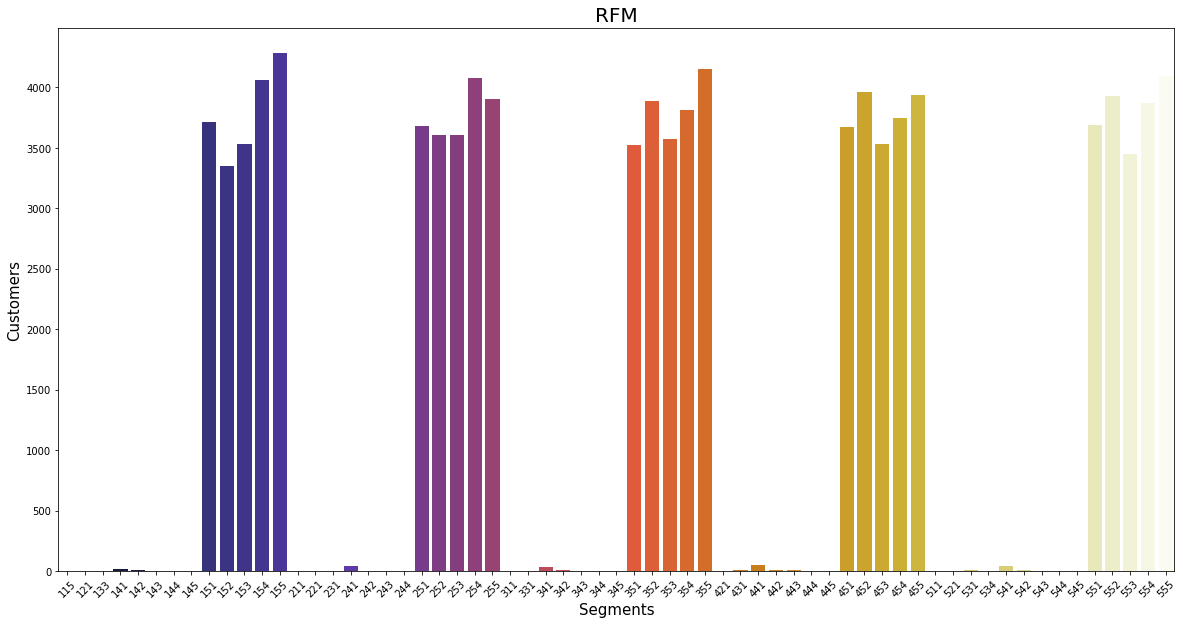

In [68]:
#визуализируем распределение по группам:
df_plot = df.groupby('RFM_Score', as_index=False).agg({'customer': 'count'})

f, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x='RFM_Score', y='customer', data=df_plot, palette='CMRmap')
plt.title('RFM', loc='center', fontsize=20)
plt.xticks(rotation=45)
ax.set_xlabel('Segments', fontsize=15)
ax.set_ylabel('Customers', fontsize=15)

к сажалению параметр F потрит всю картинку, т.к. у основной массы пользователей по 1 заказу.